<a href="https://colab.research.google.com/github/SriPradi/MyML/blob/master/Unet_CXR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## import required python libraries 
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
root_dir1= "/content/gdrive/My Drive/chest-xray-masks-and-labels/"
base_dir = root_dir + 'fastai-v3'
path = Path(base_dir);

Mounted at /content/gdrive


In [ ]:
!ls root_dir

ls: cannot access 'root_dir': No such file or directory


In [ ]:
mask_path=Path(root_dir1 + 'masks')

In [ ]:
image_path=Path(root_dir + 'CXR_png')
test_path=Path(root_dir +'test')

In [ ]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [ ]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [ ]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array


In [ ]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()


In [ ]:
dim = 256*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test =getData(dim,flag="test")

100%|██████████| 138/138 [00:46<00:00,  2.98it/s]


In [ ]:
np.shape(y_train)

(566, 512, 512)

In [ ]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])


In [ ]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
old_model=model
del model

In [ ]:
from keras.backend import manual_variable_initialization
manual_variable_initialization(True)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 50,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)





Epoch 1/50
36/36 [==============================] - 61s 649ms/step - loss: -0.3404 - dice_coef: 0.3405 - binary_accuracy: 0.6371 - val_loss: -0.5617 - val_dice_coef: 0.5617 - val_binary_accuracy: 0.7934

Epoch 00001: val_loss improved from inf to -0.56169, saving model to cxr_reg_weights.best.hdf5
Epoch 2/50
36/36 [==============================] - 19s 515ms/step - loss: -0.6321 - dice_coef: 0.6321 - binary_accuracy: 0.7794 - val_loss: -0.7763 - val_dice_coef: 0.7763 - val_binary_accuracy: 0.8818

Epoch 00002: val_loss improved from -0.56169 to -0.77635, saving model to cxr_reg_weights.best.hdf5
Epoch 3/50
36/36 [==============================] - 19s 516ms/step - loss: -0.8111 - dice_coef: 0.8111 - binary_accuracy: 0.9042 - val_loss: -0.8542 - val_dice_coef: 0.8542 - val_binary_accuracy: 0.9287

Epoch 00003: val_loss improved from -0.77635 to -0.85423, saving model to cxr_reg_weights.best.hdf5
Epoch 4/50
36/36 [==============================] - 18s 514ms/step - loss: -0.8808 - dice_coe

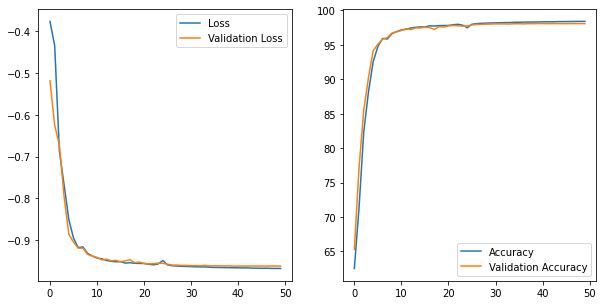

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()


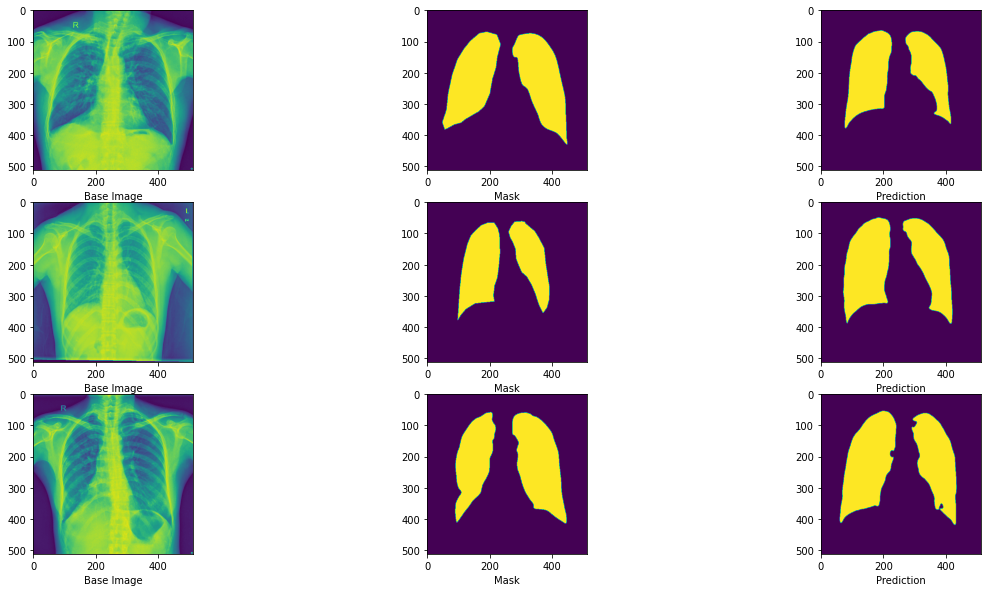

In [ ]:
pred_candidates = np.random.randint(1,test_vol.shape[0],10)
preds = model.predict(test_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
save_model(model,'/content/gdrive/My Drive/CXR_new1.hdf5')


Mounted at /content/gdrive


Import model from gdrive
Note: dice_coef_loss and dice_coef has to be defined if taken in a separate notebook

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
from keras.models import load_model
new_model=load_model('/content/gdrive/My Drive/CXR_new1.hdf5',custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

Mounted at /content/gdrive


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                     
drive = GoogleDrive(gauth)

In [ ]:
model.save('model.hdf5')
model_file = drive.CreateFile({'title' : 'model.h5'})                    
model_file.SetContentFile('model.h5')                       
model_file.Upload()

In [ ]:
# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1ZbX4kd3-lzc_PQ0nUVgQZdNiAa59owZH'})

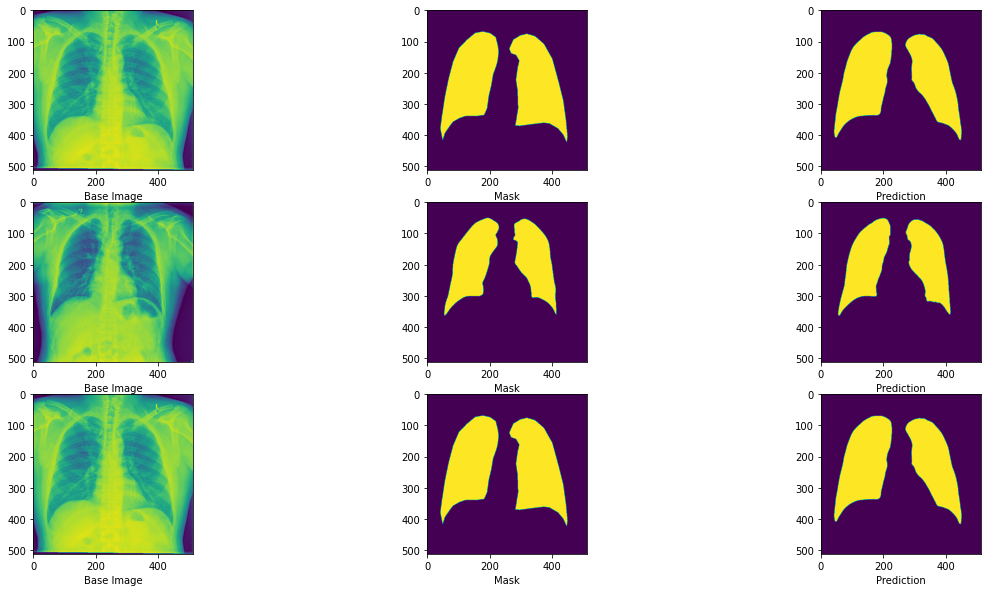

In [ ]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = new_model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir= "/content/gdrive/My Drive/"
image_path=Path(root_dir + 'chest-xray-masks-and-labels/test')

Mounted at /content/gdrive


In [ ]:
images = os.listdir(image_path)


In [ ]:
testing_files = set(os.listdir(image_path)) 

def getData(X_shape, flag = "test"):
    im_array = []
        
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
                       
            im_array.append(im)
           
        
        return im_array
    



In [ ]:
def plotMask(X):
    sample = []
    
    for i in range(6):
        left = X[i]
        sample.append(left)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()


In [ ]:
dim = 256*2
X_test = getData(dim,flag="test")

100%|██████████| 96/96 [01:35<00:00,  1.01it/s]


testing set


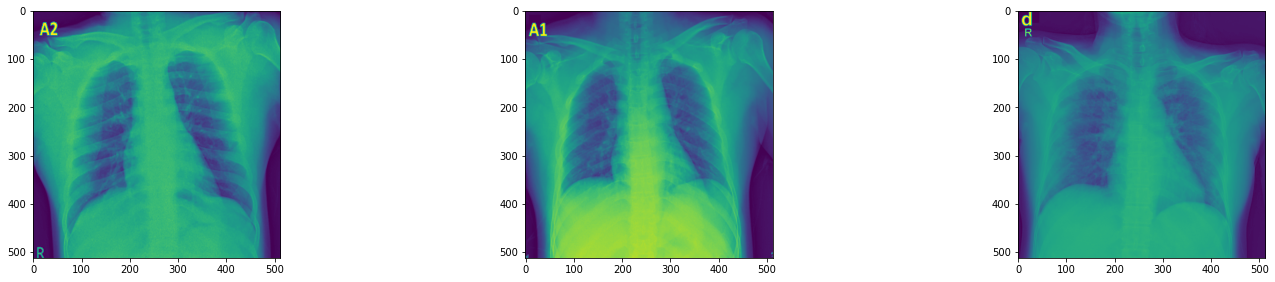

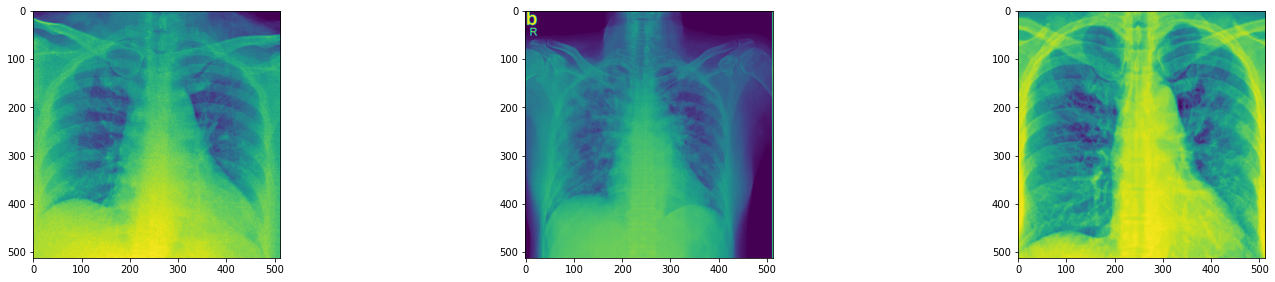

In [ ]:

print("testing set")
plotMask(X_test)

In [ ]:
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
assert X_test.shape == X_test.shape


In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

from keras.models import load_model
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
new_model=load_model('/content/gdrive/My Drive/CXR_new1.hdf5',custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})





Mounted at /content/gdrive


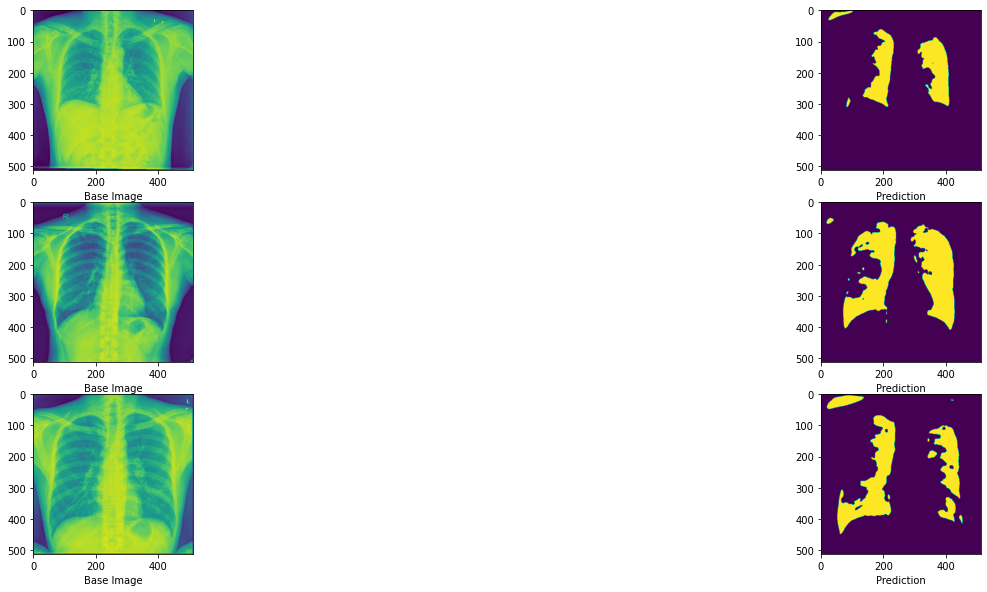

In [ ]:

pred_candidates = np.random.randint(1,X_test.shape[0],10)
preds = model.predict(X_test)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(X_test[pred_candidates[i]]))
    plt.xlabel("Base Image")
    

    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")